In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd

In [23]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [25]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [26]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [27]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [30]:
# Get a list of column names and types

inspector = inspect(engine)

print('-' * 20)

print('measurement_column')

print('-' * 20)

columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])
    
print('-' * 20)

# columns
print('station_column')

print('-' * 20)

columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c["type"])


--------------------
measurement_column
--------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
station_column
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Last_12_month

Last_12_month = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Last_12_month = ' '.join(Last_12_month) 
Last_12_month


'2017-08-23'

In [35]:
#Stackoverflow on how to convert

datetime_object = datetime.strptime(Last_12_month, '%Y-%m-%d')
datetime_object.date()
print(datetime_object.date())

2017-08-23


In [36]:
# Calculate the date 1 year ago from the last data point in the database

one_year_ago = datetime_object.date() - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [37]:
# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]

precip_query = session.query(*sel).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_query)
precip_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [41]:
# Sort the dataframe by date

sorted = precip_df.sort_values(by='date',ascending=True)

sorted = sorted.rename(columns={'prcp': 'precipitation'})

sorted.reset_index(drop=True, inplace=True)

sorted.set_index('date').head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


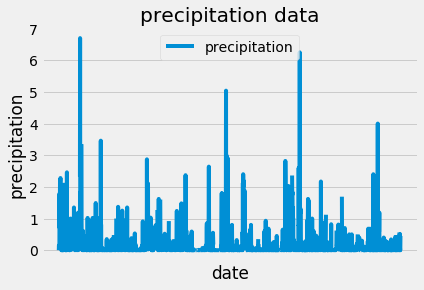

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data



sorted.plot(title='precipitation data')
plt.xticks([])
plt.legend(loc='upper center')
plt.ylabel('precipitation')
plt.xlabel('date')
plt.savefig("Images/Precipitation.png")
plt.show()

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data

sorted.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [44]:
# Design a query to show how many stations are available in this dataset?

no_of_stations = session.query(func.count(Station.station)).all()
no_of_stations

[(9)]

![precipitation](Images/precipitation.png)

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station,
                                func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded

# highest temperature recorded, and average temperature most active station?

most_active_station = session.query(func.min(Measurement.tobs), 
                                         func.max(Measurement.tobs),
                                         func.avg(Measurement.tobs)).\
                                         filter(Measurement.station=='USC00519281').all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

![describe](Images/describe.png)

In [47]:
# Choose the station with the highest number of temperature observations.

station_high_temp = session.query(Measurement.station,
                                  func.count(Measurement.tobs)).\
                                  group_by(Measurement.station).\
                                  order_by(func.count(Measurement.station).desc()).first()
station_high_temp

('USC00519281', 2772)

In [49]:
# stackoverflow how to get the first element in a list of tuples

station_hgt, val = station_high_temp
station_hgt

'USC00519281'

In [50]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and precipitation scores

# Calculate the date 1 year ago from the last data point in the database

one_year_ago = datetime_object - dt.timedelta(days=365)


temp_obsv = session.query(Measurement.tobs).\
            filter(Measurement.station == station_hgt).\
            filter(Measurement.date >= one_year_ago).all()

temp_obsv


[(77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 (66.0),
 

In [51]:
# temperature observation dataframe
temp_obsv_df = pd.DataFrame(temp_obsv)
temp_obsv_df.head()


,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


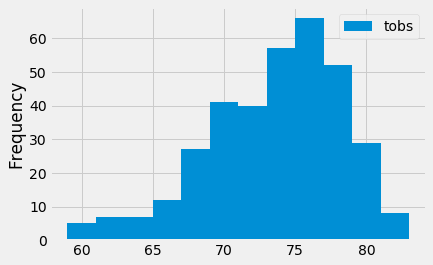

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obsv_df['tobs'].hist(bins=12, label='tobs')
plt.xlabel('')
plt.legend()
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [54]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 

# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = calc_temps('2017-01-01', '2017-01-07')
trip

[(62.0, 68.36585365853658, 74.0)]

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_temp_df


,tmin,tavg,tmax
0,62.0,68.365854,74.0


In [57]:
trip_temp_list = trip_temp_df.values.tolist()
tmin = trip_temp_list[0][0]
tavg = trip_temp_list[0][1]
tmax = trip_temp_list[0][2]

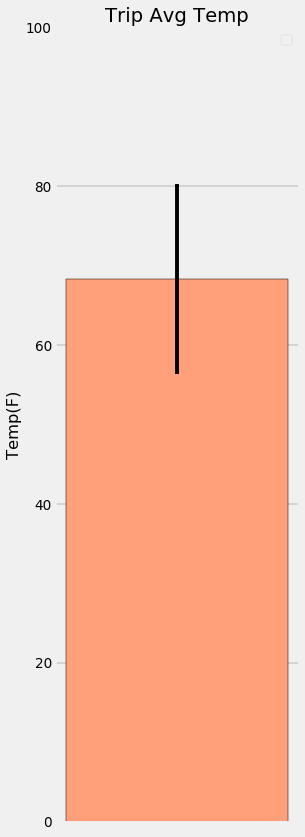

In [58]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

r1 = 0
barWidth = 10
plt.figure(figsize=(4, 14), dpi=70)
plt.bar(r1, tavg, width = barWidth, color = 'lightsalmon', edgecolor = 'black', yerr = tmax - tmin, capsize=0)
plt.xlabel('')
plt.ylabel('Temp(F)')
plt.xticks([])
plt.yticks([0,20,40,60,80,100])
plt.title('Trip Avg Temp')
plt.legend('')
plt.grid(color='lightgray', axis = 'y', linestyle='-', linewidth=2)
# Show graphh
plt.show()

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


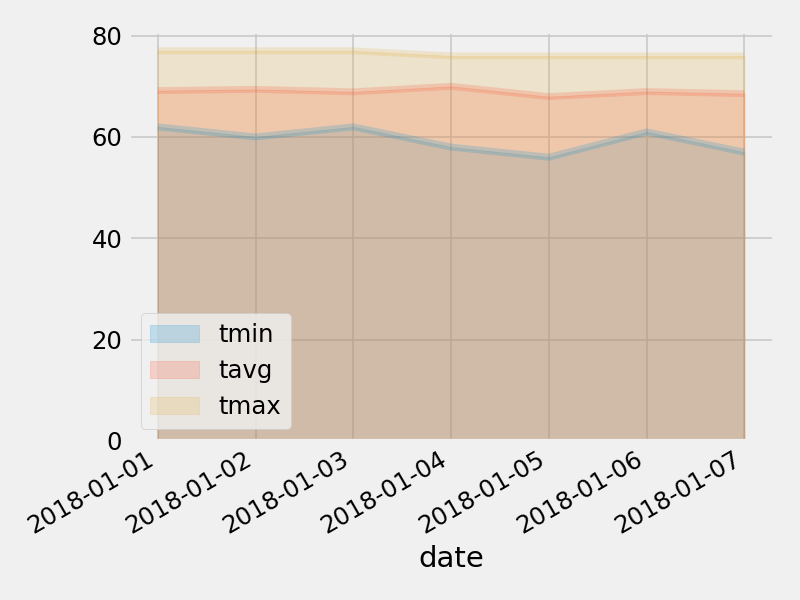

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
